# DESCRIPTION SYNOPSIS ANALYSIS

**Authors**
- Alejandro Urrego Lopéz
- Cesar Augusto Prieto Sarmiento

In this Jupyter workbook you will find the development of the analysis of the Anime descriptions, from the import of the necessary libraries to the preparation of the data and the methods used for the corresponding analysis. 

## Import necessary libraries

In [61]:
import pandas as pd   # For data manipulations
import numpy as np    # For maths
import igraph as ig   # For networks 
import openai        # AI implementations
from dotenv import load_dotenv

import os
load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')

In [2]:
# import necessary for NPL 

import nltk
nltk.download("punkt")
nltk.download("stopwords")  # Descargar el conjunto de datos de stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords

english_sw = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to C:\Users\Cesar
[nltk_data]     Prieto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Cesar
[nltk_data]     Prieto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from wordcloud import WordCloud  # For word cloud generation

# For plotting
import matplotlib.pyplot as plt
from plotnine import *
import matplotlib.colors as mcolors
import hashlib

import random # For setting random seed in plots

In [4]:
import os

data_folder_path = os.path.dirname(os.getcwd()) + os.sep + 'Data' + os.sep

## Definition of important functions

In [5]:
# Adapted from ChatGPT
def adjustcolor(color_name, alpha):
    # Convert color name to RGB
    rgb = mcolors.CSS4_COLORS.get(color_name)
    if rgb is None:
        raise ValueError(f"The color '{color_name}' is not valid.")
    
    # Convert RGB to hexadecimal
    r, g, b = mcolors.to_rgb(rgb)
    hex_color = f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}'
    
    # Add alpha channel
    return f'{hex_color}{int(255 * alpha):02x}'

In [6]:
def get_color(integer, alpha=1.0):
    # Convert the integer to a unique string using hashing
    hash_object = hashlib.sha256(str(integer).encode())
    hex_dig = hash_object.hexdigest()
    
    # Convert the hexadecimal hash to RGB values
    r = int(hex_dig[:2], 16) % 256
    g = int(hex_dig[2:4], 16) % 256
    b = int(hex_dig[4:6], 16) % 256
    
    # Format RGB values into a color string
    color = "#{:02x}{:02x}{:02x}".format(r, g, b)
    
    # Return RGB values and alpha
    return (r / 255, g / 255, b / 255, alpha)

def get_colors_for_list(integer_list, alpha=1.0):
    # Initialize an empty list to store colors
    colors = []
    
    # Iterate over the list of integers
    for integer in integer_list:
        # Get the color for each integer
        color = get_color(integer, alpha=alpha)
        # Append the color to the list
        colors.append(color)
    
    # Return the list of colors
    return colors


## Import and manipulation of the database 

In [7]:
# Read the CSV file 'anime_with_synopsis.csv' into a pandas DataFrame
# Ensure the 'id' column is read as strings (dtype={'id': str})
anime_with_synopsis = pd.read_csv(data_folder_path + 'anime_with_synopsis.csv', dtype={'id': str})

In [8]:
anime_with_synopsis['sypnopsis'][16201]

'The story takes place shortly before Cartaphilus took a nap and Chise became an auditor at the academy. Elias and his friends help Chise prepare for the academy, where in the middle of everyday life, Spriggan visits the mansion on a spooky horse with the words, "The appearance of the ghost hunting association is unusual this time." Gabriel, an ordinary boy who just moved from London, was bored of his environment of parting with friends, being in an unfamiliar location, and everything else. Sitting by the window and glancing beyond, he spotted a purple smoke and decided to chase after it, looking to escape his boredom. Though it should not, the world of the boy begins to converge with the wizards, who live on the other side behind a thick veil. (Source: MAL News)'

In [9]:
anime_with_synopsis

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [10]:
# Filter rows where the 'Genres' column does not contain 'Hentai' (a genre for adults)
anime_with_synopsis = anime_with_synopsis[~anime_with_synopsis['Genres'].str.contains('Hentai', na=False)]

# Filter rows where the 'sypnopsis' column does not contain information 
anime_with_synopsis = anime_with_synopsis[~anime_with_synopsis['sypnopsis'].str.contains('No synopsis information has been added to this title. Help improve our database by adding a synopsis here.', na=False)]

# Sort by 'MAL_ID' and reset the index
anime_with_synopsis = anime_with_synopsis.sort_values(by=['MAL_ID'], ascending=True).reset_index(drop=True)

In [11]:
anime_with_synopsis

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
15500,48471,Tsuki to Laika to Nosferatu,Unknown,"Sci-Fi, Space, Vampire",The first astronaut in human history was a vam...
15501,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
15502,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
15503,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [12]:
# Convert the 'sypnopsis' column to lowercase, remove non-alphabetic characters except spaces,
# remove extra spaces from the beginning and end of each synopsis
anime_with_synopsis["sypnopsis"] = (anime_with_synopsis.sypnopsis
                                    .str.lower()  # Convert to lowercase
                                    .str.replace("[^a-z ]", "", regex=True)  # Remove non-alphabetic characters except spaces
                                    .str.replace(" +", " ", regex=True)  # Replace multiple spaces with a single space
                                    .str.strip()  # Strip leading and trailing spaces
                                    .str.replace(r'\busic\b', 'music', regex=True)
                                   )


In [13]:
# Concatenate all synopses into a single string separated by ' | '
synopsis = anime_with_synopsis['sypnopsis'].str.cat(sep=' | ')


In [14]:
# Split the concatenated synopsis string into a list of words
synopsis = synopsis.split(' ')


## Token Creation

In [15]:
tokens = []
for word in synopsis:
    # Check if the word is not in the set of English stopwords
    if word not in english_sw:
        # If not a stopword, append the word to the tokens list
        tokens.append(word)

In [16]:
len(tokens)

602837

In [17]:
# Create a DataFrame 'Tokens' from the list of tokens, with column name 'token'
Tokens = pd.DataFrame(tokens, columns=['token'])


In [18]:
# Reemplazar tokens que contienen 'usic' por 'music'
Tokens['token'] = Tokens['token'].str.replace('usic', 'music')

In [19]:
# Calculate frequencies of each token in the 'Tokens' DataFrame
Frecuencias = (Tokens
               .groupby('token')  # Group tokens by their value
               .agg(frecuencia=("token", "count"))  # Count the frequency of each token
               .reset_index()  # Reset index to make 'token' a regular column
               .sort_values(by=["frecuencia"], ascending=False)  # Sort by frequency in descending order
               .reset_index(drop=True)  # Reset index to start from 0
              )


In [20]:
Frecuencias[0:12]

,token,frecuencia
0,|,15496
1,source,5523
2,world,3147
3,one,3127
4,school,2601
5,new,2537
6,life,2142
7,ann,2036
8,however,1967
9,girl,1883


In [83]:
# Generate a WordCloud from the tokens
wordcloud = WordCloud(
    background_color='black',  # Set background color to black
    width=3000,  # Set width of the word cloud
    height=2500,  # Set height of the word cloud
    stopwords=('|', 'source')  # Set stopwords to exclude '|' and 'source'
).generate(" ".join(tokens))  # Generate the word cloud from the joined tokens


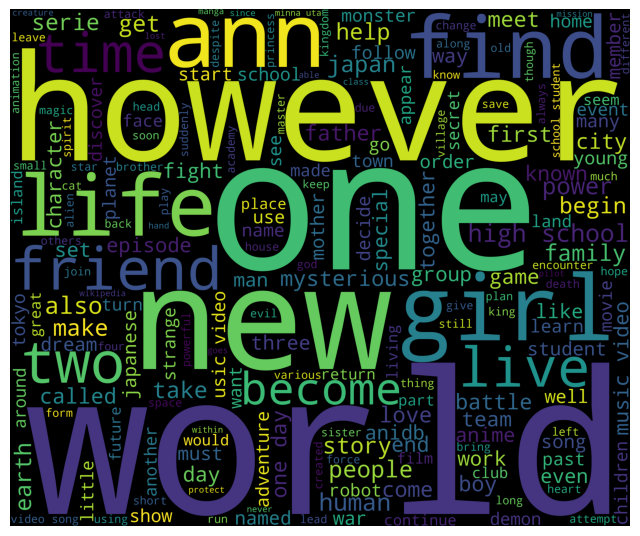

In [66]:
# Display the WordCloud using matplotlib
plt.figure(1, figsize=(8, 8))  # Create a figure with size 8x8 inches
plt.imshow(wordcloud)  # Display the wordcloud image
plt.axis('off')  # Turn off the axis
plt.show()  # Show the plot


In [40]:
### This code block is only run if you want to save the image in the working directory. 
#plt.figure(figsize=(12/2.54, 12/2.54))  # Set the scale of the plot (1 cm = 0.3937 pulgadas)

#plt.imshow(wordcloud)
#plt.axis('off')  # Ocultar los ejes

### Save the plot.
#plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight')  # bbox_inches='tight' ajusta los márgenes
#plt.show()

## Bi-grams

In [21]:
# Create bigrams from the list of tokens
Bigrama = [' '.join(tokens[i:i+2]) for i in range(0, len(tokens)-1)]


In [22]:
# Create a DataFrame 'Bigrama' from the list of bigrams, with column name 'Bigrama'
Bigrama = pd.DataFrame(Bigrama, columns=['Bigrama'])

Bigrama


,Bigrama
0,year humanity
1,humanity colonized
2,colonized several
3,several planets
4,planets moons
...,...
602831,two unavoidable
602832,unavoidable fate
602833,fate source
602834,source official


In [23]:
# Calculate frequencies of each bigram in the 'Bigrama' DataFrame
FrecuenciaBigrama = (Bigrama
                     .groupby('Bigrama')  # Group bigrams by their value
                     .agg(frecuencia=("Bigrama", "count"))  # Count the frequency of each bigram
                     .reset_index()  # Reset index to make 'Bigrama' a regular column
                     .sort_values(by=["frecuencia"], ascending=False)  # Sort by frequency in descending order
                     .reset_index(drop=True)  # Reset index to start from 0
                    )


In [24]:
FrecuenciaBigrama[0:10]

,Bigrama,frecuencia
0,source ann,2021
1,ann |,1978
2,music video,1146
3,high school,1012
4,source anidb,793
5,anidb |,790
6,| music,739
7,one day,719
8,| short,480
9,| story,399


In [25]:
# Filter out bigrams with frequency greater than 20
FrecuenciaBigrama = FrecuenciaBigrama[FrecuenciaBigrama['frecuencia'] > 20]


In [26]:
FrecuenciaBigrama[0:9]

,Bigrama,frecuencia
0,source ann,2021
1,ann |,1978
2,music video,1146
3,high school,1012
4,source anidb,793
5,anidb |,790
6,| music,739
7,one day,719
8,| short,480


In [27]:
# Split each element of the 'Bigrama' column into individual bigrams
bigramas_divididos = FrecuenciaBigrama['Bigrama'].apply(lambda x: x.split())

# Create separate lists for the first and second elements of each bigram
primer_elemento = []
segundo_elemento = []

# Iterate through each bigram in the split bigram lists
for bigrama in bigramas_divididos:
    # Check conditions to include the bigram
    if len(bigrama) == 2 and bigrama[0] != bigrama[1] and bigrama[0] != '|' and bigrama[1] != '|' and bigrama[0] != 'source' and bigrama[1] != 'source':
        # Append the first and second elements of the bigram to respective lists
        primer_elemento.append(bigrama[0])
        segundo_elemento.append(bigrama[1])
    else:
        # Print a message for bigrams not included based on conditions
        print('Bigrama no incluido: ' + str(bigrama))



Bigrama no incluido: ['source', 'ann']
Bigrama no incluido: ['ann', '|']
Bigrama no incluido: ['source', 'anidb']
Bigrama no incluido: ['anidb', '|']
Bigrama no incluido: ['|', 'music']
Bigrama no incluido: ['|', 'short']
Bigrama no incluido: ['|', 'story']
Bigrama no incluido: ['source', 'wikipedia']
Bigrama no incluido: ['wikipedia', '|']
Bigrama no incluido: ['|', 'second']
Bigrama no incluido: ['|', 'based']
Bigrama no incluido: ['|', 'fter']
Bigrama no incluido: ['series', '|']
Bigrama no incluido: ['source', 'official']
Bigrama no incluido: ['|', 'special']
Bigrama no incluido: ['source', 'mal']
Bigrama no incluido: ['news', '|']
Bigrama no incluido: ['|', 'official']
Bigrama no incluido: ['|', 'ducational']
Bigrama no incluido: ['|', 'cap']
Bigrama no incluido: ['source', 'animenfo']
Bigrama no incluido: ['animenfo', '|']
Bigrama no incluido: ['|', 'year']
Bigrama no incluido: ['|', 'series']
Bigrama no incluido: ['|', 'hen']
Bigrama no incluido: ['source', 'anime']
Bigrama no i

In [28]:
# Create a DataFrame 'Bigrama' from the lists primer_elemento and segundo_elemento
Bigrama = pd.DataFrame({'V1': primer_elemento, 'V2': segundo_elemento})


In [29]:
Bigrama

,V1,V2
0,music,video
1,high,school
2,one,day
3,video,song
4,minna,uta
...,...,...
543,getter,robo
544,dragon,balls
545,dragon,ball
546,video,included


In [30]:
# Concatenate primer_elemento and segundo_elemento lists into a single list
Concatenado = primer_elemento + segundo_elemento


In [31]:
# Obtain unique values from the list Concatenado and convert them into a DataFrame
df_tokens = pd.DataFrame({'token': list(set(Concatenado))})

# Generate unique identifiers
df_tokens['Identificador'] = range(len(df_tokens))

# Set 'Identificador' as the index
df_tokens.set_index('Identificador', inplace=True)

# Reset the index to make 'Identificador' a regular column
df_tokens.reset_index(inplace=True)


df_tokens


,Identificador,token
0,0,looks
1,1,president
2,2,irodorimidori
3,3,volumes
4,4,side
...,...,...
466,466,fictional
467,467,dreams
468,468,students
469,469,arrival


In [32]:
# Merge Bigrama with df_tokens based on 'V1' to get identifiers for the first element
# Then merge the result with df_tokens again based on 'V2' to get identifiers for the second element
Identificados = Bigrama.merge(df_tokens, left_on='V1', right_on="token", how="left") \
                      .merge(df_tokens, left_on='V2', right_on="token", how="left")


Identificados.head(10)


,V1,V2,Identificador_x,token_x,Identificador_y,token_y
0,music,video,193,music,260,video
1,high,school,453,high,266,school
2,one,day,105,one,123,day
3,video,song,260,video,80,song
4,minna,uta,432,minna,316,uta
5,school,student,266,school,42,student
6,nhks,minna,428,nhks,432,minna
7,uta,program,316,uta,96,program
8,second,season,25,second,446,season
9,tv,series,250,tv,445,series


In [33]:
# Create a DataFrame 'Aristas' containing columns 'Identificador_x' and 'Identificador_y' from 'Identificados'
Aristas = Identificados[['Identificador_x', 'Identificador_y']]

Aristas

,Identificador_x,Identificador_y
0,193,260
1,453,266
2,105,123
3,260,80
4,432,316
...,...,...
543,172,45
544,229,251
545,229,348
546,260,392


In [34]:
# Create a graph g from the DataFrame Aristas, assuming it's an undirected graph (directed=False)
g = ig.Graph.DataFrame(Aristas, directed=False)

# Assign names to the vertices based on the tokens in df_tokens
g.vs['name'] = df_tokens['token']

# Assign a color to all vertices using the adjustcolor function (assuming it returns RGBA values)
g.vs['color'] = adjustcolor('red', 0.4)

In [35]:
# Find the giant connected component (largest connected component) of the graph g
cg = g.components().giant()


In [36]:

np.random.seed(123)

# Generate a Fruchterman-Reingold layout for the giant connected component (cg)
lg = cg.layout_fruchterman_reingold()

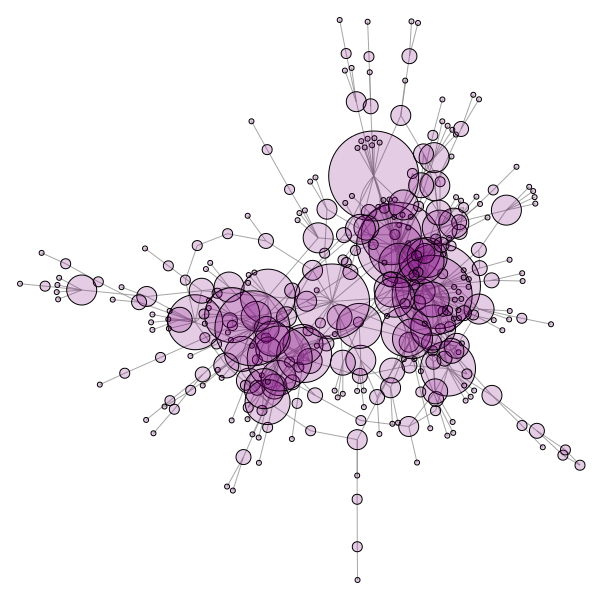

In [37]:
# Define vertex labels as dictionary where each vertex index is mapped to its index converted to string
vertex_labels = {v.index: str(v.index) for v in cg.vs}

# Plot the graph with labels
ig.plot(cg,
        layout=lg,  # Use the previously defined layout
        vertex_label_dist=0.5,  # Adjust distance of vertex labels from vertices
        vertex_label_color='black',  # Set color of vertex labels
        vertex_label_size=10,  # Set size of vertex labels
        vertex_color=adjustcolor("purple", 0.2),  # Set color of vertices
        vertex_size=[cg.degree()[v.index] * 5 if cg.degree()[v.index] * 5 > 3 else 3 for v in cg.vs],  # Set size of vertices based on degree
        edge_color=adjustcolor('gray', 0.7),  # Set color of edges
        background=None  # Set background color to None (transparent)
        )


In [38]:
# Calculate graph metrics
distancia_media = g.average_path_length()  # Average path length
grado_medio = sum(g.degree()) / len(g.vs)  # Average degree
grado_desviacion = g.assortativity_degree()  # Degree assortativity
numero_clan = len(g.largest_cliques()[0])  # Size of the largest clique
densidad = g.density()  # Graph density
transitividad = g.transitivity_undirected()  # Graph transitivity
asortatividad = g.assortativity_degree()  # Assortativity

# Print the results
print("Average path length:", distancia_media)
print("Average degree:", grado_medio)
print("Degree assortativity:", grado_desviacion)
print("Size of the largest clique:", numero_clan)
print("Graph density:", densidad)
print("Graph transitivity:", transitividad)
print("Assortativity:", asortatividad)


Average path length: 5.2920951394540205
Average degree: 2.326963906581741
Degree assortativity: 0.04672384549040784
Size of the largest clique: 3
Graph density: 0.0049509870352803
Graph transitivity: 0.04815618221258135
Assortativity: 0.04672384549040784


In [39]:
np.random.seed(12)

# Community detection algorithm by edge betweenness
eb = cg.community_edge_betweenness()

# Community detection algorithm Infomap
im = cg.community_infomap()

# Community detection algorithm Label Propagation
lp = cg.community_label_propagation()

# Community detection algorithm Leading eigenvector
le = cg.community_leading_eigenvector()

# Community detection algorithm Walktrap
wt = cg.community_walktrap()

# Community detection algorithm Spinglass
sg = cg.community_spinglass()

# Community detection algorithm Multilevel
ml = cg.community_multilevel()


In [71]:
# Convert the results into clustering objects
eb_clustering = eb.as_clustering()
wt_clustering = wt.as_clustering()

# Print the modularity of each community detection method
print("Modularity of community_edge_betweenness:", round(eb_clustering.modularity, 3))
print("Modularity of community_infomap:", round(im.modularity, 3))
print("Modularity of community_label_propagation:", round(lp.modularity, 3))
print("Modularity of community_leading_eigenvector:", round(le.modularity, 3))
print("Modularity of community_walktrap:", round(wt_clustering.modularity, 3))
print("Modularity of community_spinglass:", round(sg.modularity, 3))
print("Modularity of community_multilevel:", round(ml.modularity, 3))

Modularity of community_edge_betweenness: 0.716
Modularity of community_infomap: 0.664
Modularity of community_label_propagation: 0.635
Modularity of community_leading_eigenvector: 0.69
Modularity of community_walktrap: 0.648
Modularity of community_spinglass: 0.725
Modularity of community_multilevel: 0.72


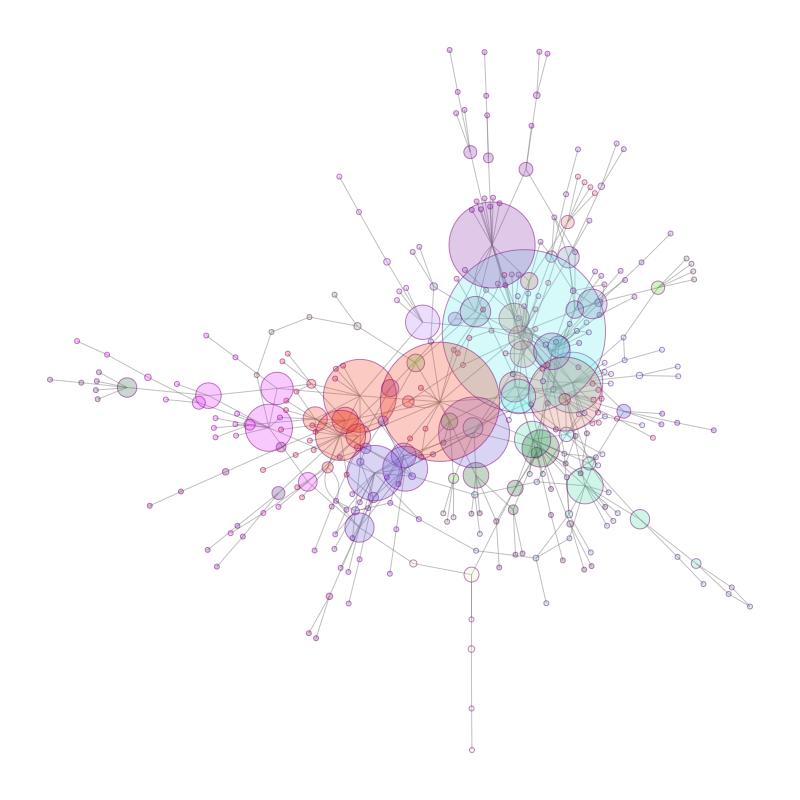

In [70]:
import igraph as ig

# Plot the graph with specified parameters
ig.plot(cg,
        layout=lg,  # Use the previously defined layout
        edge_color=adjustcolor('gray', 0.5),  # Set edge color
        vertex_frame_color=adjustcolor('purple', 0.5),  # Set vertex frame color
        vertex_color=get_colors_for_list(sg.membership, alpha=0.25),  # Color vertices based on community membership
        vertex_size=[cg*0.01 if cg*0.01 > 5 else 5 for cg in cg.betweenness()],  # Adjust vertex size based on betweenness centrality
        bbox=(800, 800),  # Set bounding box size for the plot
        margin=50  # Set margin size
        )


In [72]:
# Get the indices of vertices in the giant component
giant_component_indices = g.components().giant().vs.indices

# Filter tokens belonging to the giant component
Componente_Gigante = df_tokens.query('Identificador in @ giant_component_indices')

# Assign community membership detected by different algorithms

# Edge Betweenness algorithm membership
Componente_Gigante['edge_betweenness'] = eb.as_clustering().membership

# Infomap algorithm membership
Componente_Gigante['infomap'] = im.membership

# Label Propagation algorithm membership
Componente_Gigante['label_propagation'] = lp.membership

# Leading Eigenvector algorithm membership
Componente_Gigante['leading_eigenvector'] = le.membership

# Walktrap algorithm membership
Componente_Gigante['walktrap'] = wt.as_clustering().membership

# Spinglass algorithm membership
Componente_Gigante['spinglass'] = sg.membership

# Multilevel algorithm membership
Componente_Gigante['multilevel'] = ml.membership



C:\Users\Cesar Prieto\AppData\Local\Temp\ipykernel_2616\4159479112.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Cesar Prieto\AppData\Local\Temp\ipykernel_2616\4159479112.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Cesar Prieto\AppData\Local\Temp\ipykernel_2616\4159479112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [73]:
set(sg.membership)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

In [80]:
# Initialize the dictionary
diccionario = {}

# Iterate over the clusters
for c in set(sg.membership):
    # Filter tokens for the current cluster and reset index
    tokens_sorted = Componente_Gigante.query('edge_betweenness == @c').reset_index(drop=True)['token']
    
    # Concatenate tokens into a single string
    theme = ' '.join(tokens_sorted)
    
    # Add to the dictionary
    diccionario['cluster ' + str(c)] = theme

# Print the resulting dictionary
print(diccionario)


{'cluster 0': 'looks falls identity thus boarding mobile', 'cluster 1': 'president strange entire life join shoujo', 'cluster 2': 'irodorimidori volume second theme embark bddvd ova release officer click traffic half hello hatsune passed four man chance ducational outside bluraydvd show daily kousuke character bluray parents left games solar council named shell team across name must', 'cluster 3': 'volumes finds card main special fight prix civil ago united girls ever save nanke amusement threat ghost times martial specials age even school learn academy lives universal', 'cluster 4': 'side traditional planet family put cap suddenly months girl six come rock ability find also childrens younger official beautiful getter lord youtube music birthday vacation bond taken lost osamu along new films agency franchise fairy uta nohara', 'cluster 5': 'present student short cure yet friends college', 'cluster 6': 'production lupin eagle edo go nature battle nothing realizes edogawa tale alien enco

In [81]:
anime_with_synopsis['sypnopsis'].fillna(value='Nulo', inplace=True)

In [82]:
veces = {}

# Iterates over each key 'c' in the dictionary 'diccionario'
for c in diccionario:
    
    # Defines a function 'calculate' that checks if an element is in the cluster 'diccionario[c]'
    def calculate(element, cluster=diccionario[c]):
        return element in cluster  # Checks if the element is in the cluster

    # Applies the 'calculate' function to each synopsis and sums the results to count occurrences of elements from the cluster in the synopsis
    veces[str(c)] = anime_with_synopsis['sypnopsis'].apply(lambda x: sum(map(calculate, x.split(' '))))

# Note: This structure may be somewhat complex and could be inefficient for large datasets and dictionaries.


In [83]:
df = pd.DataFrame(veces)

In [84]:
df

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14,cluster 15,cluster 16
0,8,10,30,10,23,0,31,12,18,16,14,23,14,25,16,7,9
1,8,11,27,11,22,0,27,16,17,16,16,16,10,24,14,8,10
2,11,11,32,9,26,0,35,15,18,24,13,27,14,33,19,8,7
3,4,5,11,7,7,0,12,4,6,13,6,8,6,14,5,5,5
4,4,5,31,5,20,1,30,8,16,20,8,14,8,23,9,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15500,8,9,28,14,20,1,30,12,15,18,11,17,13,23,13,9,7
15501,4,6,16,7,12,2,21,6,9,9,6,9,6,18,6,3,4
15502,0,0,0,1,1,0,3,1,0,2,2,0,0,2,0,0,1
15503,0,0,0,0,2,0,1,0,0,0,1,0,0,0,0,0,0


In [85]:
# Combine DataFrames horizontally
combined_df = pd.concat([anime_with_synopsis, df], axis=1)

# Export the combined DataFrame to a CSV file
combined_df.to_csv('combined_anime_bd.csv', index=False)


In [86]:
combined_df

,MAL_ID,Name,Score,Genres,sypnopsis,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,...,cluster 7,cluster 8,cluster 9,cluster 10,cluster 11,cluster 12,cluster 13,cluster 14,cluster 15,cluster 16
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",in the year humanity has colonized several of ...,8,10,30,10,23,...,12,18,16,14,23,14,25,16,7,9
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",other day another bountysuch is the life of th...,8,11,27,11,22,...,16,17,16,16,16,10,24,14,8,10
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",vash the stampede is the man with a bounty on ...,11,11,32,9,26,...,15,18,24,13,27,14,33,19,8,7
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,4,5,11,7,7,...,4,6,13,6,8,6,14,5,5,5
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",it is the dark century and the people are suff...,4,5,31,5,20,...,8,16,20,8,14,8,23,9,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15500,48471,Tsuki to Laika to Nosferatu,Unknown,"Sci-Fi, Space, Vampire",the first astronaut in human history was a vam...,8,9,28,14,20,...,12,15,18,11,17,13,23,13,9,7
15501,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...,4,6,16,7,12,...,6,9,9,6,9,6,18,6,3,4
15502,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",sequel to higurashi no naku koro ni gou,0,0,0,1,1,...,1,0,2,2,0,0,2,0,0,1
15503,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",new yama no susume anime,0,0,0,0,2,...,0,0,0,1,0,0,0,0,0,0


In [87]:
PromptInicio = [
    'Utilizando el diccionario de clusters de palabras proporcionado a continuación, extrae el tema o tópico que más se relacione con cada cluster:',
    'Ten en cuenta que las palabras fueron obtenidas mediante un método de agrupamiento de una red asociada a bigramas sacados de un texto, también ten en cuenta que las palabras vienen de mayor a menor importancia'
]
PromptFinal = [
    'Al momento de devolver los datos contesta con el siguiente formato: Numerodecluster:[dato] TemaoTopicoPrincipal:[dato] Solo contesta con el formato suministrado. Ten en cuenta que los datos vienen de descripciones de animes'
]

# Constructing the request by joining prompts, dictionary, and final prompts
request = " ".join(PromptInicio) + str(diccionario) + " ".join(PromptFinal)


In [90]:

request = request
chat_completion = openai.chat.completions.create(
    model="gpt-4-1106-preview",
    messages=[
        {
            "role": "user",
            "content": request,
        }
    ],
    max_tokens=2000,  # Aumenta la cantidad de tokens permitidos
    temperature=0.7,  # Reduce la "creatividad" para obtener respuestas precisas
    top_p=1,  # Ajusta la probabilidad máxima para asegurar respuestas precisas
)
respuesta = chat_completion.choices[0].message.content


In [91]:
print(respuesta)

0: Tema o Tópico Principal: Tecnología y transformación de identidad
1: Tema o Tópico Principal: Política y vida surreal
2: Tema o Tópico Principal: Lanzamientos y aventuras de medios
3: Tema o Tópico Principal: Competencias y desafíos sobrenaturales
4: Tema o Tópico Principal: Cultura tradicional y aventuras espaciales
5: Tema o Tópico Principal: Vida estudiantil y amistad
6: Tema o Tópico Principal: Enfrentamientos históricos y ciencia ficción
7: Tema o Tópico Principal: Misterio y espionaje
8: Tema o Tópico Principal: Eventos culturales y poderes sobrenaturales
9: Tema o Tópico Principal: Crecimiento juvenil y fantasía
10: Tema o Tópico Principal: Ciencia ficción y vida escolar
11: Tema o Tópico Principal: Música y enfrentamientos épicos
12: Tema o Tópico Principal: Poderes especiales y búsquedas de verdad
13: Tema o Tópico Principal: Vida escolar y fenómenos sobrenaturales
14: Tema o Tópico Principal: Lanzamientos y vida escolar
15: Tema o Tópico Principal: Magia y conflictos final